## Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Javascript, display
from typing import Tuple
import numpy as np
from IPython.display import display, Markdown, Math, HTML

## Modelling

System equation of motion for a simple pendulum of negligible rod mass.

$$
   \ddot{\theta} = - \frac{g}{\ell} \sin \theta - c \omega
$$

Where:

+ $g \approx 9.81 \; m/s^2$ - Gravity accleration
+ $m = 1 \; \text{kg}$ - mass of the pendulum bod (point-mass)
+ $\ell = 1 \; m$  rod length
+ $c$ - Experimental viscuous friction coefficient.
+ $\omega$ - Angular velocity in rad/s
+ $\theta$ - Pendulum angle in radians

State space model

$$
  \dot{\mathbf{w}} = \frac{d}{dt} 
                          \begin{bmatrix} \theta \\ \omega \end{bmatrix}
                   = \begin{bmatrix}
                       \omega \\ -g / \ell \sin \theta - c \omega 
                    \end{bmatrix}
$$

where the state space vector is $\mathbf{w} = (\theta, \omega)$

## Simulation

Define function that represents the state-space model equation.

In [2]:
def wdot(w, t, m, g, c, l):
    # Extract state space variables from the state space vector
    theta, omega = w
    # Compute the derivative of the state space vector
    dw = np.array([omega, -g/l * np.sin(theta) - c * omega])
    return dw
    

In [3]:
np.set_printoptions(precision=4, floatmode="fixed", suppress=True)


Function for solving ODEs (Ordinary Differential Equations) using runge Kutta 4th Order

In [10]:
def ode_rk4(f, wi: np.ndarray, dt: float, te: float, **params) -> Tuple[np.ndarray, np.ndarray]:
    """Solve ODE using 4th order Runge Kutta numerical method.

    Solve first-order ODE (Ordinary Differential Equation) 
    in the form

        d
        -- w = f(t, w, **params)
        dt
    
    Parameters
    ----------
    f : Function[[np.ndarray, float], np.ndarray]
        Function that represents the right-hand side of the 
        state space differential equation wdot.
    wi: np.ndarray
        Initial value of the state space vector.
    dt: float
        Time interval in seconds
    t:  float
        Final time
    **params:
        Optional constant parameters to be passed to f.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        Returns the t, W, where t is the time vector and W is time 
        series of the state space variables. The column i of W is 
        the time series of w[i], the state variable i of the state 
        space vector w.
    """
    t = 0
    ti = 0
    w = wi
    # Number of state variables
    n = len(wi) 
    # Number of steps
    m = int((te - ti) / dt)
    assert m >= 0
    # Time series of the state space variables
    W = np.zeros((m, n))
    # Time vector
    t_ = np.zeros((m, 1))
    # Index
    i = 0 
    while i < m:
        k1 = f(w, t, **params)
        k2 = f(w + 1/2 * k1 * dt, t + 1/2 * dt, **params)
        k3 = f(w + 1/2 * k2 * dt, t + 1/2 * dt, **params) 
        k4 = f(w + k3 * dt, t + dt, **params)
        w = w + dt/6*(k1 + 2 * k2 + 2 * k3 + k4)
        W[i,:] = w
        t_[i] = t
        t = t + dt
        i = i + 1
    return (t_, W)

Define simulation parameters

In [11]:
pi = np.pi 
degrees = np.pi / 180.0
c = 2.5             # pendulum damping factor
g = 9.81            # gravity acceleration m/s^2
l = 1.0             # rod length
m = 1.0             # bod mass - 1 kg 
qi = 115 * degrees  # Initial angle (q represents theta)
wi = 0.0            # Initial angular velocity (w represents omega)
te = 3.0            # Final/End time t
dt_ms = 20          # ODE Integration time interval in milliseconds
                    # It is also the time interval between animation frames.
dt = dt_ms / 1000   # dt - "ODE" integration time interval in seconds

Set the initial state, also known as initical condition.

In [12]:
wi = np.array([qi, wi])

Solve the differential equation using RK4 - 4th order Runge Kutta Algorithm.

In [13]:
t, W = ode_rk4(wdot, wi, dt = dt, te = 3, g = g, m = m, l = m, c = c)

Display some results

In [14]:
np.c_[t, W][:20,:]

array([[ 0.0000,  2.0054, -0.1735],
       [ 0.0200,  2.0002, -0.3388],
       [ 0.0400,  1.9919, -0.4966],
       [ 0.0600,  1.9804, -0.6475],
       [ 0.0800,  1.9660, -0.7920],
       [ 0.1000,  1.9488, -0.9306],
       [ 0.1200,  1.9288, -1.0637],
       [ 0.1400,  1.9063, -1.1918],
       [ 0.1600,  1.8812, -1.3152],
       [ 0.1800,  1.8537, -1.4340],
       [ 0.2000,  1.8239, -1.5486],
       [ 0.2200,  1.7918, -1.6591],
       [ 0.2400,  1.7575, -1.7656],
       [ 0.2600,  1.7212, -1.8682],
       [ 0.2800,  1.6828, -1.9668],
       [ 0.3000,  1.6425, -2.0614],
       [ 0.3200,  1.6004, -2.1520],
       [ 0.3400,  1.5565, -2.2384],
       [ 0.3600,  1.5109, -2.3204],
       [ 0.3800,  1.4637, -2.3980]])

Plot the results of the simulation

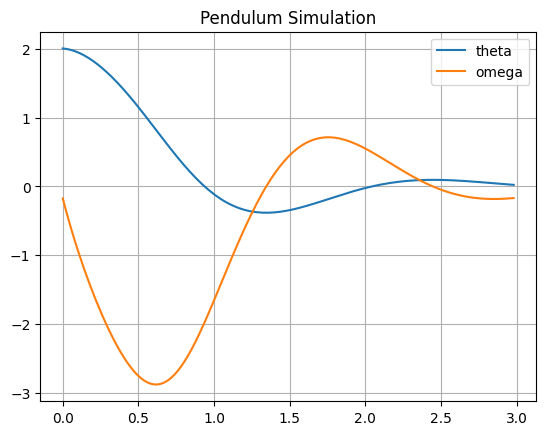

In [15]:
plt.plot(t, W)
plt.title("Pendulum Simulation")
plt.legend([r"theta", r"omega"])
plt.grid()

## Pendulum Animation - jshtml

In [20]:
fig, ax = plt.subplots()
plt.xlim(-1.2, +1.2)
plt.ylim(-1.5, 0.5)
ax.set_aspect("equal")
rod, = ax.plot([], [], color = "blue", animated = True)
bod, = ax.plot([], [], 'o', color = "blue", markersize = 20 , animated = True)
x_path = []; y_path = [];
path, = ax.plot([], [], 'r', animated = True)

def draw_init():
    theta = W[0, 0]
    x_bod = l * np.sin(theta)
    y_bod = -l * np.cos(theta)
    bod.set_data([x_bod], [y_bod])
    rod.set_data([0, x_bod], [0, y_bod])
    x_path.append(x_bod)
    y_path.append(y_bod)
    path.set_data(x_path, y_path)
    return (bod, rod, path)

def draw_frame(i: int):
    theta = W[i,0]
    #print(" [TRACE] Pendulum angle = ", theta)
    x0 = 0
    y0 = 0
    x_bod = l * np.sin(theta)
    y_bod = -l * np.cos(theta)
    bod.set_data([x_bod], [y_bod])
    x_path.append(x_bod)
    y_path.append(y_bod)
    rod.set_data([x0, x_bod], [y0, y_bod])
    path.set_data(x_path, y_path)
    return (bod, rod, path)

anim = FuncAnimation(fig
                    , draw_frame
                    , init_func = draw_init
                    , frames = len(t)
                    , interval = dt_ms
                    , blit = True)
plt.grid()
plt.title("Pendulum animation")
plt.close(anim._fig)

# Animation in Javascript 3 megabytes in disk space ugage.
# Each frame is encoded as a base64 string of a png image.
HTML(anim.to_jshtml())

## Pendulum Animation (Simulation) - Video

In [21]:
fig, ax = plt.subplots()
plt.xlim(-1.2, +1.2)
plt.ylim(-1.5, 0.5)
ax.set_aspect("equal")
rod, = ax.plot([], [], color = "blue", animated = True)
bod, = ax.plot([], [], 'o', color = "blue", markersize = 20 , animated = True)
x_path = []; y_path = [];
path, = ax.plot([], [], 'r', animated = True)

def draw_init():
    theta = W[0, 0]
    x_bod = l * np.sin(theta)
    y_bod = -l * np.cos(theta)
    bod.set_data([x_bod], [y_bod])
    rod.set_data([0, x_bod], [0, y_bod])
    x_path.append(x_bod)
    y_path.append(y_bod)
    path.set_data(x_path, y_path)
    return (bod, rod, path)

def draw_frame(i: int):
    theta = W[i,0]
    #print(" [TRACE] Pendulum angle = ", theta)
    x0 = 0
    y0 = 0
    x_bod = l * np.sin(theta)
    y_bod = -l * np.cos(theta)
    bod.set_data([x_bod], [y_bod])
    x_path.append(x_bod)
    y_path.append(y_bod)
    rod.set_data([x0, x_bod], [y0, y_bod])
    path.set_data(x_path, y_path)
    return (bod, rod, path)

anim = FuncAnimation(fig
                    , draw_frame
                    , init_func = draw_init
                    , frames = len(t)
                    , interval = dt_ms
                    , blit = True)
plt.grid()
plt.title("Pendulum animation")
plt.close(anim._fig)

# mp4 video HTML5 video animation. More efficiency in disk space
# usage. The video uses less than 1 megabyte.
HTML(anim.to_html5_video())